In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [2]:
sql = """
SELECT
  month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [3]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2015-08-01,03N,C88023,112,0.1004,86609.78
1,2015-08-01,12F,N85015,1,-2.4335,53604.94
2,2015-08-01,05R,M84024,2,-6.2000,41315.75
3,2015-08-01,01H,A82020,2,3.1000,120905.37
4,2015-08-01,08F,F82648,0,0.0000,17080.55


# Practice level data

In [4]:
practice = ghost_df.copy()
practice['calc_val'] = practice['possible_savings']/practice['net_cost']
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2013-05-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
669712,2013-05-01,00K,A81001,3,3.2850,32027.35,0.000103
323335,2013-06-01,00K,A81001,3,-2.1272,27785.40,-0.000077
587697,2013-07-01,00K,A81001,0,0.0000,30353.65,0.000000
276561,2013-08-01,00K,A81001,3,3.3522,30748.65,0.000109
716480,2013-09-01,00K,A81001,1,32.1800,29544.21,0.001089


# CCG level data

In [5]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = ccg['possible_savings']/ccg['net_cost']
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2013-05-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
33,00C,2013-05-01,1599,182.1012,837980.56,0.000217
34,00C,2013-06-01,937,262.1197,765673.64,0.000342
35,00C,2013-07-01,723,597.9922,838610.10,0.000713
36,00C,2013-08-01,775,107.6665,815297.72,0.000132
37,00C,2013-09-01,815,229.1338,771885.32,0.000297


In [6]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
## here we calculate ranges for december 2012
ccg_dec18 = ccg.copy().loc[(ccg["month"]== "2018-12-01")]
ccg_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,196.00,196.00,196.00,196.00
mean,14252.16,4430.38,1784261.53,0.00
std,20319.74,6088.59,1046548.64,0.00
min,71.00,-197.52,50003.30,-0.00
25%,568.50,72.26,1150486.67,0.00
50%,4477.50,1590.20,1523225.40,0.00
75%,21404.00,6701.10,2073027.21,0.00
max,142769.00,34664.49,7234775.70,0.02


# Most recent month map
- I think still some missing CCGs here?

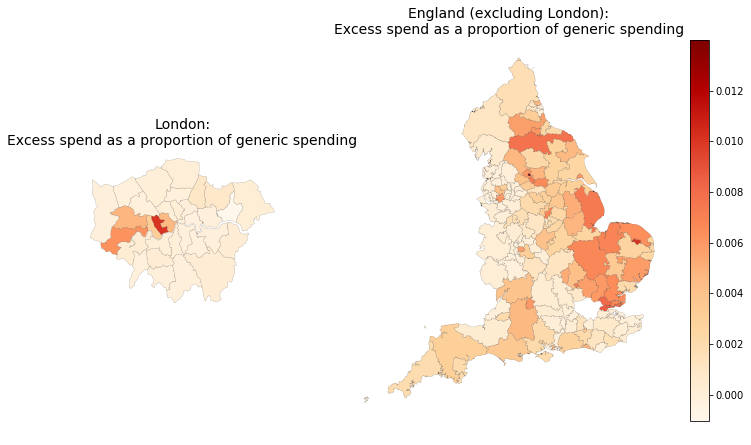

In [8]:
plt.figure(figsize=(12, 7))
ccg_for_map = ccg.loc[ccg['pct']!='112']
last_month = ccg_for_map.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title="Excess spend as a proportion of generic spending", column='calc_val', 
             separate_london=True)
plt.show()

# Declie plots

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


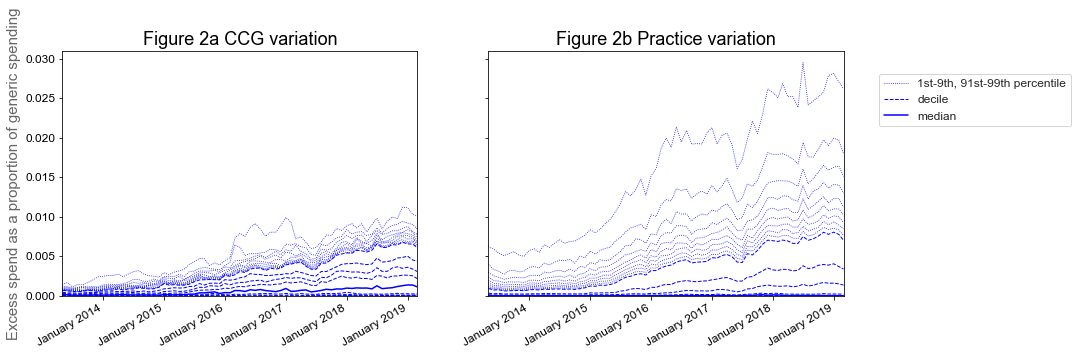

In [9]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="Figure 2a CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Figure 2b Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# Total items and total excess costs

In [10]:
totals = practice.groupby('month').sum()

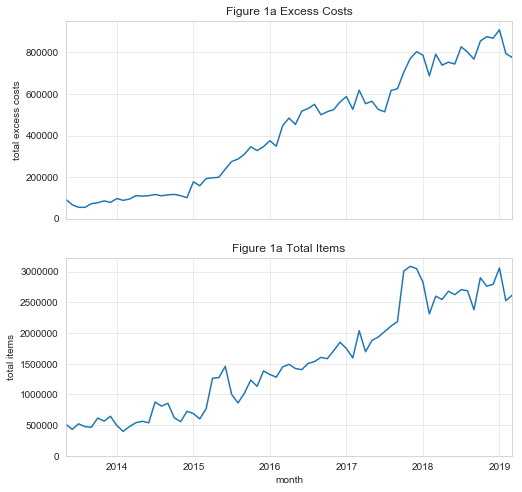

In [11]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = totals['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.set_title('Figure 1a Excess Costs')
ax = totals['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
ax.set_ylim(0,)
ax.set_title('Figure 1a Total Items')
plt.savefig('Fig 1.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## Annual totals
Ignore 2013 and 2019, as they're not complete years

In [12]:
totals[['items','possible_savings','net_cost']].resample('Y').sum()

,items,possible_savings,net_cost
month,,,
2013-12-31,4230540,579186.29,2923176703.55
2014-12-31,7451006,1275098.39,4399345122.25
2015-12-31,12682756,3052386.53,4653745679.59
2016-12-31,18160750,5807246.05,4538026084.68
2017-12-31,26362166,7409786.86,4548889822.26
2018-12-31,31827681,9496024.33,4220776576.84
2019-12-31,8205775,2479163.77,1030645877.80


# Stratify by EHR

Rerun GPSoC file aggregation if new months need to be added:

In [13]:
#%run -i "GPSoC/make_csv.py"

In [14]:
epr = pd.read_csv('GPSoC/complete.csv')
epr = epr.rename(index=str, columns={"Principal Supplier": "Principal_Supplier",
                                     "Principal System": "Principal_System"})
epr['Date'] = pd.to_datetime(epr['Date'])
epr.loc[epr['Principal_Supplier']=='TPP','Principal_Supplier'] = 'SystmOne'
epr.loc[epr['Principal_Supplier']=='INPS','Principal_Supplier'] = 'Vision'
epr = epr.drop('Unnamed: 0', axis=1)
epr.head()

,Date,ODS,Principal_Supplier,Principal_System
0,2016-04-01,A81622,SystmOne,SystmOne (GPSoC)
1,2016-04-01,A82018,EMIS,EMIS Web
2,2016-04-01,A82041,EMIS,EMIS Web
3,2016-04-01,A86026,SystmOne,SystmOne (GPSoC)
4,2016-04-01,B81120,SystmOne,SystmOne (GPSoC)


In [15]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
first = epr.loc[epr['Date']=='2016-03-01',['ODS','Principal_Supplier']]
last = epr.loc[epr['Date']=='2018-12-01',['ODS','Principal_Supplier']]
by_epr = numbers.merge(epr, how='left', left_on=['practice','month'], right_on=['ODS','Date'])
by_epr = by_epr.merge(first,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_first')
                     )
'''by_epr = by_epr.merge(last,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_last')
                     )'''
by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier'] = by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier_first']
#by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier'] = by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier_last']
by_epr = by_epr.drop(columns=['Date',
                              'ODS',
                              'Principal_System',
                              'ODS_first',
                              'Principal_Supplier_first'])#,
                              #'ODS_last',
                              #'Principal_Supplier_last'])
by_epr['Principal_Supplier'] = by_epr['Principal_Supplier'].str.strip()
by_epr = by_epr.groupby(['month','Principal_Supplier']).sum()
by_epr = by_epr.unstack()
by_epr.head()

possible_savings                                net_cost  \
Principal_Supplier             EMIS Microtest SystmOne  Vision         EMIS   
month                                                                         
2013-05-01                 10446.77   1784.29 73738.64 5581.46 203238163.99   
2013-06-01                 -2563.73   1859.71 63388.98 2988.00 188462254.12   
2013-07-01                -10055.73    785.86 61007.63 2142.51 203442934.51   
2013-08-01                 -3948.33    534.06 57048.07  979.68 195651805.43   
2013-09-01                  9180.06    736.48 60155.03  885.89 190777930.29   

                                                        
Principal_Supplier  Microtest     SystmOne      Vision  
month                                                   
2013-05-01         5170136.52 135160903.38 26857906.96  
2013-06-01         4789722.81 124830516.81 25017331.23  
2013-07-01         5204418.73 134816177.08 26813963.72  
2013-08-01         5093040.22 130271807.21 25866000.03  
2013-09-01         4851201.65 125962964.12 25384134.39

## Total possible savings

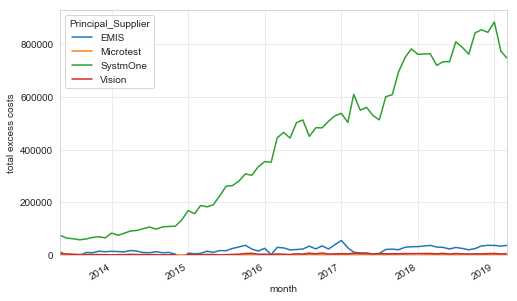

In [16]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = by_epr['possible_savings'].plot(ax=ax)
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
plt.savefig('savings_by_EHR.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## Total savings/total generic prescribing costs

In [17]:
measure = by_epr['possible_savings'] / by_epr['net_cost']
measure.head()

Principal_Supplier,EMIS,Microtest,SystmOne,Vision
month,,,,
2013-05-01,0.00,0.00,0.00,0.00
2013-06-01,-0.00,0.00,0.00,0.00
2013-07-01,-0.00,0.00,0.00,0.00
2013-08-01,-0.00,0.00,0.00,0.00
2013-09-01,0.00,0.00,0.00,0.00


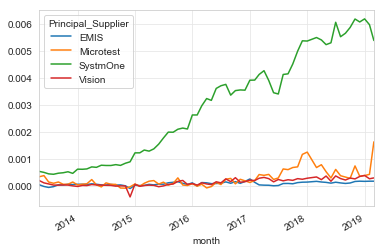

In [18]:
measure.plot()

# SystmOne Only

In [19]:
systmone = by_epr['possible_savings']['SystmOne']
systmone.head()

month
2013-05-01   73738.64
2013-06-01   63388.98
2013-07-01   61007.63
2013-08-01   57048.07
2013-09-01   60155.03
Name: SystmOne, dtype: float64

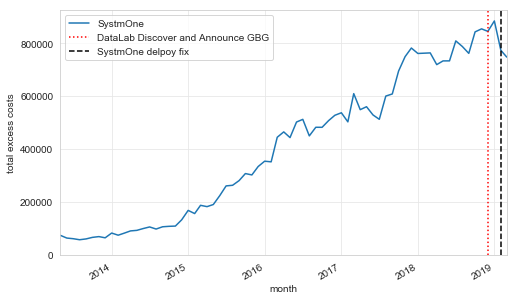

In [20]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = systmone.plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Discover and Announce GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne delpoy fix') ## it was last week of Feb, I think a case for setting as march
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.legend()
plt.savefig('systmone_only.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# Top ten GBG chemicals in 2018

In [21]:
sql = """
WITH
  chem_map AS(
  SELECT
    DISTINCT chemical_code,
    chemical
  FROM
    ebmdatalab.hscic.bnf)
SELECT
  SUBSTR(bnf_code,1,9) AS chem_code,
  chemical,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS excess_spend
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
LEFT JOIN
  chem_map
ON
  SUBSTR(bnf_code,1,9) = chemical_code
WHERE
  month >= '2018-01-01'
  AND month <= '2018-12-01'
GROUP BY
  chem_code,
  chemical
ORDER BY
  excess_spend DESC
"""
by_chem = bq.cached_read(sql, csv_path='by_chem.zip')

In [22]:
by_chem.head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694635.63
1,0408010AE,Pregabalin,159404,665385.08
2,0411000G0,Memantine Hydrochloride,100178,512712.62
3,0303020G0,Montelukast,241626,298153.93
4,0402010AD,Aripiprazole,18605,269940.04
5,0205052N0,Losartan Potassium,786568,269048.04
6,0402010AB,Quetiapine,89215,235940.00
7,0206020A0,Amlodipine,2719024,219620.47
8,0403010X0,Trazodone Hydrochloride,26253,213470.67
9,0603020T0,Prednisolone,103825,180958.73


In [23]:
by_chem.sort_values('items',ascending=False).head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694635.63
16,0103050P0,Omeprazole,3664839,133583.12
13,0103050L0,Lansoprazole,2827832,153589.42
7,0206020A0,Amlodipine,2719024,219620.47
46,0601022B0,Metformin Hydrochloride,1283610,39942.21
24,0204000H0,Bisoprolol Fumarate,1186282,102676.65
12,0209000C0,Clopidogrel,1130301,167058.98
32,0212000Y0,Simvastatin,1002033,60841.19
59,040702040,Tramadol Hydrochloride,985668,30974.86
47,0602010V0,Levothyroxine Sodium,889756,39727.58
